# PDEs modeled with LSTMs
In this notebook you will use LSTM update rules to solve a nonlinear PDE called Burgers' equation.

In [8]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.rnn_layers import *
from cs231n.rom_utils import load_burg_data, sample_burg_minibatch
from cs231n.classifiers.rom_rnn import PDEmodelRNN
from cs231n.rom_solver import PDESolver

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load BURG data
We will use the BURG dataset for finding the PDE solutions.

In [9]:
# Load BURG data from disk; this returns a dictionary
train_data = load_burg_data('snaps_0p05_0p02_5.dat','snaps_0p05_0p02_1.dat')
val_data = load_burg_data('snaps_0p05_0p02_2p5.dat')

# Print out all the keys and values from the data dictionary
def print_data(data):
    for k, v in data.iteritems():
      if type(v) == np.ndarray:
        print k, type(v), v.shape, v.dtype
        if k == 'features':
            for i in v:
                print i
        else:
            for i in v:
                print i.shape   
      else:
        print k, type(v), len(v)
    
print 'train'
print_data(train_data)
print 'val'
print_data(val_data)

train
features <type 'numpy.ndarray'> (2L, 3L) float64
[ 0.05  0.02  5.  ]
[ 0.05  0.02  1.  ]
solutions <type 'numpy.ndarray'> (2L, 501L, 1000L) float64
(501L, 1000L)
(501L, 1000L)
val
features <type 'numpy.ndarray'> (1L, 3L) float64
[ 0.05  0.02  2.5 ]
solutions <type 'numpy.ndarray'> (1L, 501L, 1000L) float64
(501L, 1000L)


## Look at the BURG data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `load_burg_data` function from the file `cs231n/rom_utils.py` to get data. Run the following to show the parameters and their Burgers' equation solutions.

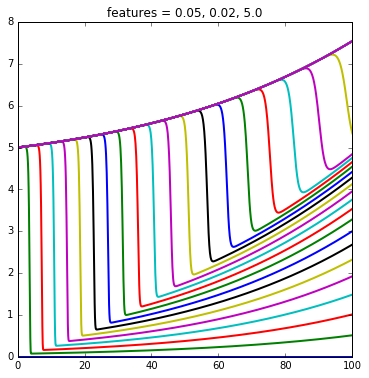

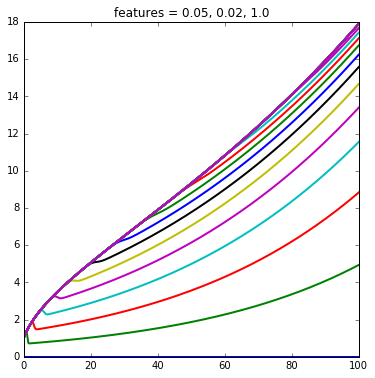

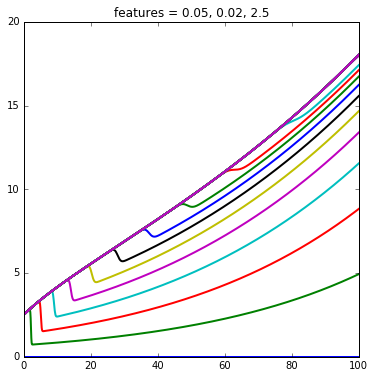

In [10]:
# Show the parameters and solutions
def plot_it(data, i=0, j=1, v_indices = np.array([0])):
    fig = plt.figure(figsize=(6,6))
    vspace = np.linspace(0.0, 100.0, 1000)[:, None]
    if i == 999:
        v = data[::j].T
        plot_title = 'features = ?'
    else:        
        v = data['solutions'][i][::j].T
        plot_title = 'features = %s'%', '.join(str(e) for e in data['features'][i])
    plt.plot(vspace, v, lw=2)
    plt.title(plot_title)
    plt.show()

plot_it(train_data, 0, 20)
plot_it(train_data, 1, 20)
plot_it(val_data, 0, 20)

# LSTM PDE solving model
Updated the implementation of the `loss` method of the `PDEmodelRNN` class in the file `cs231n/classifiers/rom_rnn.py` to handle the L2 squared loss and created PDEmodelRNN to handle burg inputs instead of image captioning system. 

# Overfit PDE solver LSTM model
Run the following to overfit an LSTM model on the same small dataset.

(Iteration 1 / 300) loss: 45425580.357115
(Iteration 11 / 300) loss: 19275634.788654
(Iteration 21 / 300) loss: 4518833.066504
(Iteration 31 / 300) loss: 7727438.061461
(Iteration 41 / 300) loss: 39167944.764492
(Iteration 51 / 300) loss: 19267632.790247
(Iteration 61 / 300) loss: 17563204.644663
(Iteration 71 / 300) loss: 15675841.073167
(Iteration 81 / 300) loss: 7747258.123718
(Iteration 91 / 300) loss: 6681420.216053
(Iteration 101 / 300) loss: 15902208.870781
(Iteration 111 / 300) loss: 7830548.313586
(Iteration 121 / 300) loss: 4954645.490204
(Iteration 131 / 300) loss: 3055545.943856
(Iteration 141 / 300) loss: 4163936.821242
(Iteration 151 / 300) loss: 5269256.550449
(Iteration 161 / 300) loss: 3642152.486138
(Iteration 171 / 300) loss: 3839746.042132
(Iteration 181 / 300) loss: 8219023.694009
(Iteration 191 / 300) loss: 33344433.964529
(Iteration 201 / 300) loss: 5498391.577968
(Iteration 211 / 300) loss: 15472772.474776
(Iteration 221 / 300) loss: 5383345.031380
(Iteration 23

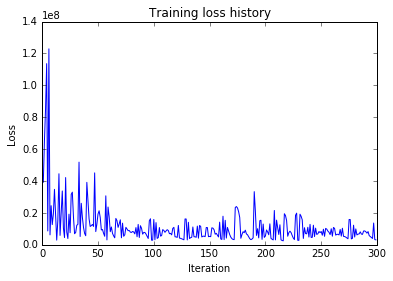

In [39]:
small_lstm_model = PDEmodelRNN(
          cell_type='lstm',
          input_dim=train_data['features'].shape[1],
          hidden_dim=15,
          hidden_dim2=500,
          solution_dim=1000,
          dtype=np.float32,
        )

small_lstm_solver = PDESolver(small_lstm_model, train_data,
           update_rule='adam',
           num_epochs=150,
           batch_size=1,
           optim_config={'learning_rate': 7e-2,},
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM result samples
Visualize some samples.

[[ 0.05  0.02  5.  ]]
(501L, 1000L)
(501L, 1000L)


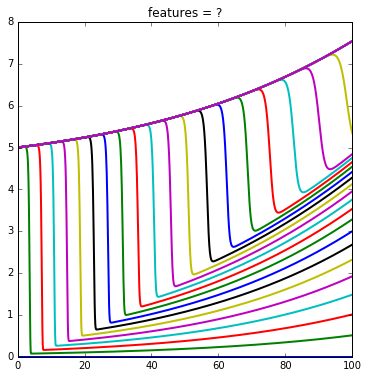

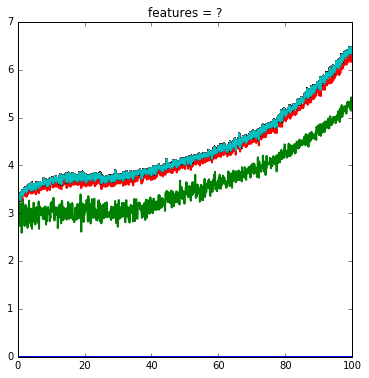

[[ 0.05  0.02  2.5 ]]
(501L, 1000L)
(501L, 1000L)


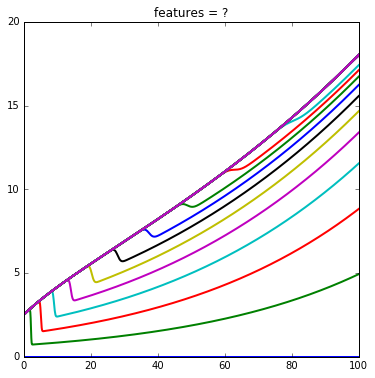

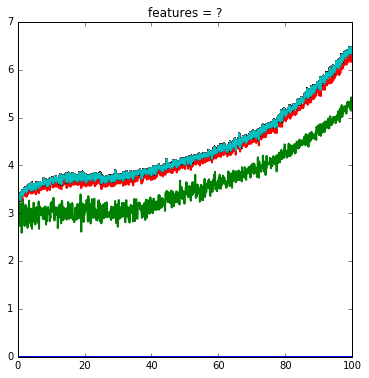

In [40]:
for data in [train_data, val_data]:
  minibatch = sample_burg_minibatch(data, batch_size=1)
  gt_solutions, features = minibatch
  sample_solutions = small_lstm_model.sample(features)
  print features
  print gt_solutions[0,:,:].shape
  print sample_solutions[0,:,:].shape
  plot_it(gt_solutions[0,:,:], 999, 20)
  plot_it(sample_solutions[0,:,:], 999, 1)


# Train an LSTM PDE solving model!
Using the pieces you have implemented in this and the previous notebook, try to train a PDE solving model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validatation set that are better than random.

Don't spend too much time on this part; we don't have any explicit accuracy thresholds you need to meet.

(Iteration 1 / 600) loss: 10182989.351328
(Iteration 11 / 600) loss: 17176245.290827
(Iteration 21 / 600) loss: 8373769.018733
(Iteration 31 / 600) loss: 6294218.519116
(Iteration 41 / 600) loss: 6355252.998627
(Iteration 51 / 600) loss: 9136715.164158
(Iteration 61 / 600) loss: 5196115.771190
(Iteration 71 / 600) loss: 8998218.136133
(Iteration 81 / 600) loss: 5668638.913018
(Iteration 91 / 600) loss: 7888626.172753
(Iteration 101 / 600) loss: 5581278.891203
(Iteration 111 / 600) loss: 4998638.216454
(Iteration 121 / 600) loss: 4211290.482192
(Iteration 131 / 600) loss: 9489911.319478
(Iteration 141 / 600) loss: 11583529.789511
(Iteration 151 / 600) loss: 4987985.616425
(Iteration 161 / 600) loss: 4689703.480344
(Iteration 171 / 600) loss: 7477430.545109
(Iteration 181 / 600) loss: 5690733.336319
(Iteration 191 / 600) loss: 9234070.695584
(Iteration 201 / 600) loss: 6510552.755933
(Iteration 211 / 600) loss: 8505351.560124
(Iteration 221 / 600) loss: 8055966.989831
(Iteration 231 / 60

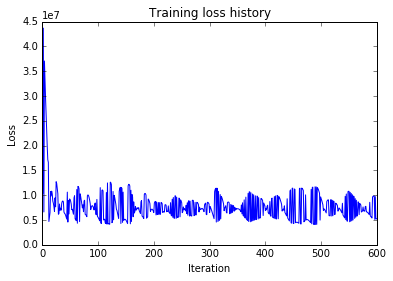

In [32]:
good_lstm_model = PDEmodelRNN(
          cell_type='lstm',
          input_dim=train_data['features'].shape[1],
          hidden_dim=30,
          hidden_dim2=500,
          solution_dim=1000,
          dtype=np.float32,
        )

good_lstm_solver = PDESolver(good_lstm_model, train_data,
           update_rule='adam',
           num_epochs=300,
           batch_size=1,
           optim_config={'learning_rate': 5e-2,},
           lr_decay=0.995,
           verbose=True, print_every=10,
         )


good_lstm_solver.train()

# Plot the training losses
plt.plot(good_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM result samples
Visualize samples from  improved model.

[[ 0.05  0.02  1.  ]]


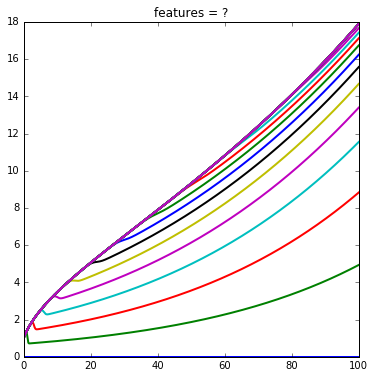

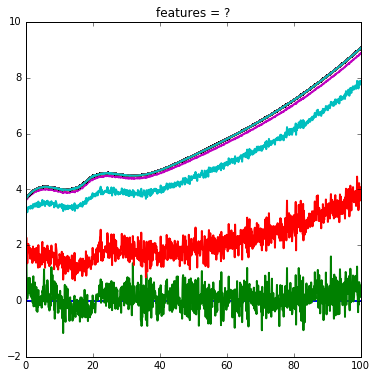

[[ 0.05  0.02  2.5 ]]


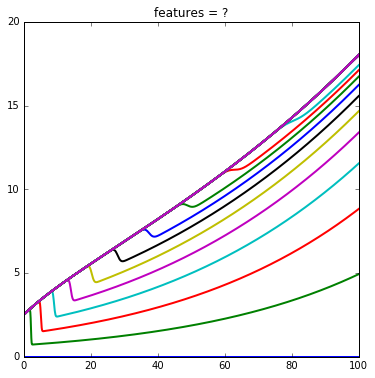

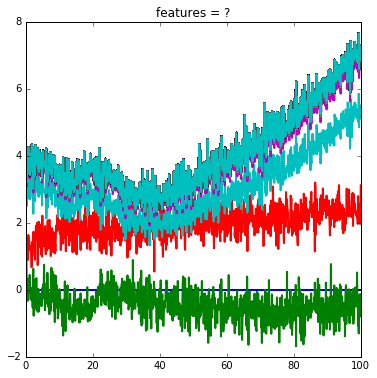

In [33]:
for data in [train_data, val_data]:
  minibatch = sample_burg_minibatch(data, batch_size=1)
  gt_solutions, features = minibatch
  sample_solutions = good_lstm_model.sample(features)
  print features
  #print gt_solutions.shape 
  #print sample_solutions.shape
  plot_it(gt_solutions[0,:,:], 999, 20)
  plot_it(sample_solutions[0,:,:], 999, 1)